In [1]:
# This notebook was built on Google colab and uses data form google drive
# Also the notebook was built using multiple sessions saving the intermediate outputs to avoid overshooting the RAM

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import networkx as nx
import csv
import random
import pickle

### Generating data for class 0

class 1: edge exists<br>
class 0 : edge does not exist<br>
We have 1862220 nodes and 9437519 edges. i.e. 9437519 data points with class 1<br><br>

We need to generate data points where the edge does not exist<br>
Total possible 1 to 1 edges are 1862220 * 1862219 = 3467861466180
<br>
We have a lot of possible 1 to 1 edges missing<br><br>

Let's take a sample of those missing edges which will serve as class 0<br>


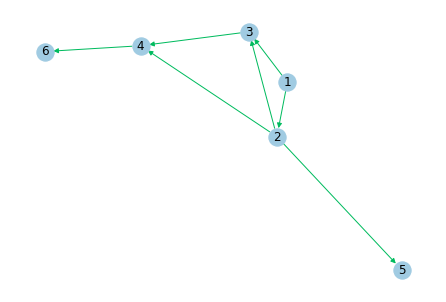

In [5]:
dg = nx.DiGraph()
dg.add_edge(1, 2)
dg.add_edge(1, 3)
dg.add_edge(2, 3)
dg.add_edge(3, 4)
dg.add_edge(2, 5)
dg.add_edge(2, 4)
dg.add_edge(4, 6)

pos=nx.spring_layout(dg)
# pos=graphviz_layout(dg)
nx.draw(dg,pos,node_color='#A0CBE2',edge_color='#00bb5e',width=1,edge_cmap=plt.cm.Blues,with_labels=True)

In above graph,<br>
1 follows 2 & 3<br>
2 & 3 follow 4<br>
1 does not directly follow 4. However there's very high chance that 1 will follow 4 as the shortest path between 1 and 4 is 2.<br><br>

Therefore, we will only sample those points for class 0 where shortest path >2<br>
For e.g. We will have (1,6) as a data point for class 0

In [6]:
parent_folder = "/content/drive/MyDrive/AAIC/Projects/Facebook Friend Recommendation /data"
without_header_filepath = parent_folder + "/train_without_header.csv"

In [7]:
g = nx.read_edgelist(without_header_filepath, delimiter=',', create_using=nx.DiGraph(), nodetype=int)

In [8]:
f = csv.reader(open(without_header_filepath, 'r'))

edges = dict()

for edge in f:
    edges[(edge[0], edge[1])] = 1

In [9]:
missing_edges = set()

while len(missing_edges)<100:
    user1 = random.randint(1, 1862220)
    user2 = random.randint(1, 1862220)
    path_exists = edges.get((user1, user2), 0)

    if (path_exists==0) and (user1 != user2):
        #checking if edge exists and shortest path length > 2
        try:
            if nx.shortest_path_length(G=g, source=user1, target=user2)>2:
                missing_edges.add((user1, user2))
            else:
                continue
        #if path doesn't exist
        except:
            missing_edges.add((user1, user2))
    else:
        continue


pickle.dump(missing_edges,open(parent_folder+'/missing_edges.p','wb'))

In [10]:
path = parent_folder+'/missing_edges.p'
missing_edges = pickle.load(open(path,'rb'))

In [11]:
len(missing_edges)

9437519

### Train Test Split

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import pickle
import networkx as nx

In [2]:
parent_folder = "/content/drive/MyDrive/AAIC/Projects/Facebook Friend Recommendation /data"
train_csv = parent_folder + "/train.csv"
missing_edges_pickle = parent_folder+'/missing_edges.p'
missing_edges = pickle.load(open(missing_edges_pickle,'rb'))

In [3]:
df_pos = pd.read_csv(train_csv)
df_neg = pd.DataFrame(list(missing_edges), columns=['source_node', 'destination_node'])

In [4]:
df_pos.head()

,source_node,destination_node
0,1,690569
1,1,315892
2,1,189226
3,2,834328
4,2,1615927


In [5]:
df_neg.head()

,source_node,destination_node
0,601436,1322692
1,891928,411442
2,114606,1845732
3,669241,486296
4,941565,676512


In [6]:
print("Number of nodes in the graph with edges", df_pos.shape[0])
print("Number of nodes in the graph without edges", df_neg.shape[0])

Number of nodes in the graph with edges 9437519
Number of nodes in the graph without edges 9437519


In [7]:
X_train_pos, X_test_pos, y_train_pos, y_test_pos  = train_test_split(df_pos,np.ones(len(df_pos)),test_size=0.2, random_state=9)
X_train_neg, X_test_neg, y_train_neg, y_test_neg  = train_test_split(df_neg,np.zeros(len(df_neg)),test_size=0.2, random_state=9)

In [8]:
print("Number of nodes in the train data graph with edges", X_train_pos.shape[0],"=",y_train_pos.shape[0])
print("Number of nodes in the train data graph without edges", X_train_neg.shape[0],"=", y_train_neg.shape[0])
print()
print("Number of nodes in the test data graph with edges", X_test_pos.shape[0],"=",y_test_pos.shape[0])
print("Number of nodes in the test data graph without edges", X_test_neg.shape[0],"=",y_test_neg.shape[0])

Number of nodes in the train data graph with edges 7550015 = 7550015
Number of nodes in the train data graph without edges 7550015 = 7550015

Number of nodes in the test data graph with edges 1887504 = 1887504
Number of nodes in the test data graph without edges 1887504 = 1887504


In [9]:
X_train_pos.to_csv(parent_folder +'/train_pos.csv',header=False, index=False)
X_test_pos.to_csv(parent_folder +'/test_pos.csv',header=False, index=False)
X_train_neg.to_csv(parent_folder +'/train_neg.csv',header=False, index=False)
X_test_neg.to_csv(parent_folder +'/test_neg.csv',header=False, index=False)

### Find common and unique nodes in train and test graph

In [81]:
import numpy as np
import pandas as pd
import networkx as nx

In [82]:
parent_folder = "/content/drive/MyDrive/AAIC/Projects/Facebook Friend Recommendation /data"

In [83]:
train_graph = nx.read_edgelist(parent_folder +'/train_pos.csv', delimiter=',', create_using=nx.DiGraph(), nodetype=int)
test_graph = nx.read_edgelist(parent_folder +'/test_pos.csv', delimiter=',', create_using=nx.DiGraph(), nodetype=int)

In [84]:
train_nodes_pos = set(train_graph.nodes())
test_nodes_pos = set(test_graph.nodes())

In [85]:
total_common_nodes = len(train_nodes_pos.intersection(test_nodes_pos))
total_nodes_only_in_train = len(train_nodes_pos - test_nodes_pos)
total_nodes_only_in_test = len(test_nodes_pos - train_nodes_pos)

print(f"Total common nodes in train and test graph :{total_common_nodes}")
print(f"Total nodes present in train graph and not in test graph :{total_nodes_only_in_train}")
print(f"Total nodes present in test graph and not in train graph :{total_nodes_only_in_test}")
print(f"% of nodes present in test graph and not in train graph {format(total_nodes_only_in_test/len(test_nodes_pos)*100)} %")

Total common nodes in train and test graph :1063125
Total nodes present in train graph and not in test graph :717597
Total nodes present in test graph and not in train graph :81498
% of nodes present in test graph and not in train graph 7.1200735962845405 %


We have a cold start problem<br>
i.e. there are ~7% of the users in the test data for whom we do not have any information about their network.

### Preparing data

In [86]:
X_train_pos = pd.read_csv(parent_folder +'/train_pos.csv', names=['source_node', 'destination_node'])
X_test_pos = pd.read_csv(parent_folder +'/test_pos.csv', names=['source_node', 'destination_node'])
X_train_neg = pd.read_csv(parent_folder +'/train_neg.csv', names=['source_node', 'destination_node'])
X_test_neg = pd.read_csv(parent_folder +'/test_neg.csv', names=['source_node', 'destination_node'])

In [87]:
y_train_pos = np.ones(X_train_pos.shape[0])
y_train_neg = np.zeros(X_train_neg.shape[0])

y_test_pos = np.ones(X_test_pos.shape[0])
y_test_neg = np.zeros(X_test_neg.shape[0])

In [88]:
X_train = X_train_pos.append(X_train_neg,ignore_index=True)
y_train = np.concatenate((y_train_pos,y_train_neg))
X_test = X_test_pos.append(X_test_neg,ignore_index=True)
y_test = np.concatenate((y_test_pos,y_test_neg))

In [89]:
print(f"Train data shape : {X_train.shape}, Labels shape : {y_train.shape}")
print(f"Test data shape : {X_test.shape}, Labels shape : {y_test.shape}")

Train data shape : (15100030, 2), Labels shape : (15100030,)
Test data shape : (3775008, 2), Labels shape : (3775008,)


In [90]:
X_train.to_csv(parent_folder + '/train_after_eda.csv',header=False,index=False)
X_test.to_csv(parent_folder + '/test_after_eda.csv',header=False,index=False)
pd.DataFrame(y_train.astype(int)).to_csv(parent_folder + '/train_y.csv',header=False,index=False)
pd.DataFrame(y_test.astype(int)).to_csv(parent_folder + '/test_y.csv',header=False,index=False)